In [ ]:
# default_exp core

# Blurry

> **Blurry** detects faces in photos and blurs them to increase privacy.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import cv2
import numpy as np
import fastcore
import math
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

### For Streamlit ###
import streamlit as st
import base64
from io import BytesIO

Helper function to show cv2 images in Jupyter notebook

In [ ]:
#export
def show_cv2(img: np.ndarray) -> None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img))

Simple Gaussian blur

In [ ]:
#export
def blur(img: np.ndarray, factor=1, sigma_x=0) -> np.ndarray:
    h, w, _ = img.shape
    kernel_size = max(w,h) / 3
    kernel_size *= factor
    kernel_size = math.ceil(kernel_size)
    # Make sure that kernel size is an odd number
    if kernel_size % 2 == 0:
        kernel_size += 1
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma_x)

Testing `blur`:

In [ ]:
test_img = cv2.imread('test_images/small.jpg')
assert test_img.shape == blur(test_img).shape, "Function should not change shape of array"
assert test_img.shape == blur(test_img, factor=0.5).shape, "Factors < 1 should work"
tiny = np.zeros((5,5,3), dtype = np.uint8)
assert tiny.shape == blur(tiny, factor=10).shape, "Blur function should work also when kernel size > image size"

In [ ]:
def image_row(*images: list, from_cv2=True, figsize=(12,6), **kwargs) -> None :
    n_of_images = len(images)
    fig, axes = plt.subplots(1, n_of_images, figsize=figsize, **kwargs)
    #fig.tight_layout()
    for ax, img in zip(axes, images):
        if from_cv2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_axis_off()

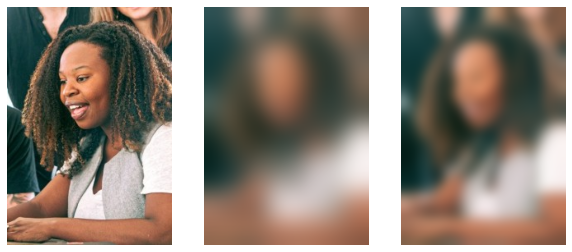

In [ ]:
image_row(test_img, blur(test_img), blur(test_img, factor=0.5), figsize=(10,5))

In [ ]:
#export
def pixelate(img: np.ndarray, factor=1) -> np.ndarray:
    h, w, _ = img.shape
    aspect_ratio = h/w
    # New sizes
    small_h, small_w = 10/factor*aspect_ratio, 10/factor
    # Make sure resized version is at least 1 pixel in both dimensions and Integer
    small_h, small_w = int(max(1, small_h)), int(max(1, small_w))
    small = cv2.resize(img, (small_w, small_h), interpolation=cv2.INTER_LINEAR)
    output = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
    return output

Test `pixelate`:

In [ ]:
assert test_img.shape == pixelate(test_img).shape, "Function should not change shape of array"
assert len(np.unique(test_img)) > len(np.unique(pixelate(test_img))), "Number of unique colors should have been reduced"
assert len(np.unique(pixelate(test_img, factor=0.5))) > len(np.unique(pixelate(test_img, factor=5))), "Large factor should reduce number of unique colors"
tiny = np.zeros((5,5,3), dtype = np.uint8)
assert tiny.shape == pixelate(tiny).shape, "Pixelate function should also work on tiny images"

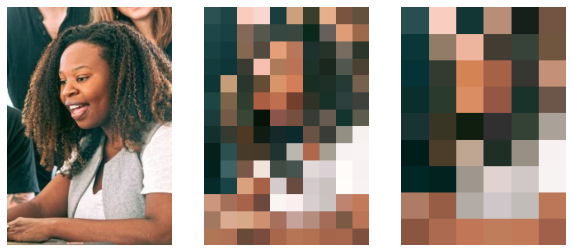

In [ ]:
image_row(test_img, pixelate(test_img), pixelate(test_img, factor=1.5), figsize=(10,5))

### Find faces
Using pretrained haar cascade from OpenCV.

In [ ]:
group_img = cv2.imread('test_images/group.jpg')

In [ ]:
#export
def find_faces(img):
    "Finds faces in a picture and returns tuples of (x, y, w, h) for each face"
    assert Path('haarcascade_frontalface_default.xml').is_file(), "haarcascade file not found"
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

In [ ]:
faces = find_faces(group_img)
assert len(faces) == 7, "there should be 7 faces in the group test image"

Does it work?

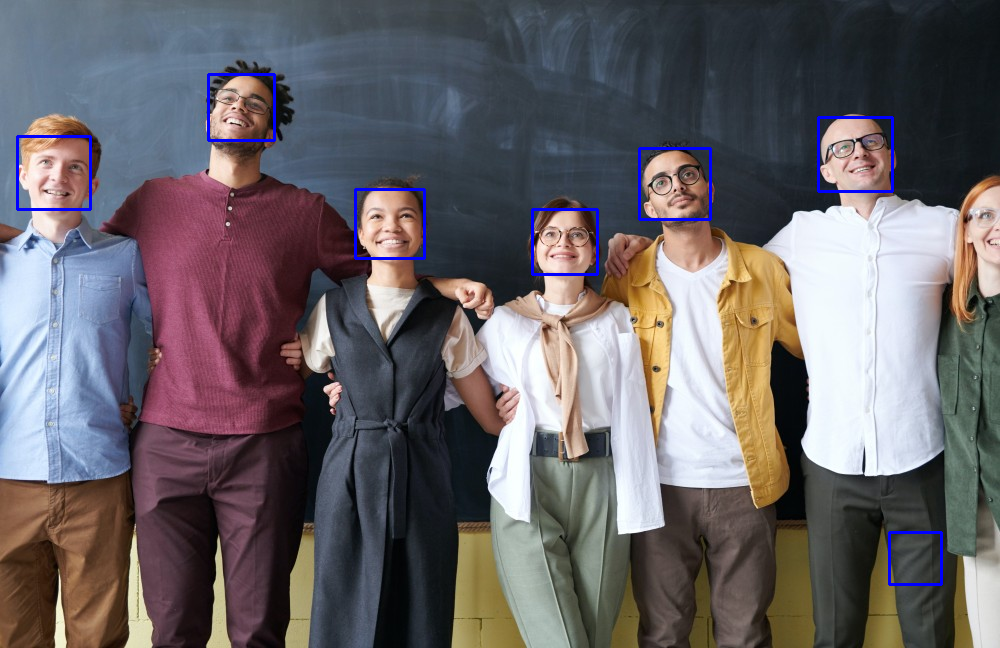

In [ ]:
img = group_img.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
show_cv2(img)

In [ ]:
#export
def blur_areas(img, areas, factor=1, blur_func=blur):
    """
    Blurs defined areas in a cv2 image.
    
    Inputs:
    img: cv2 image in BGR format
    areas: tuples of (x, y, w, h)
    factor: increase (>1.0) or decrease (<1.0) default blurring
    degrade_func: `blur` or `pixelate` (or any function that takes
        the arguments `image` and `factor`)
    
    Returns:
    cv2 image in BGR format
    """
    
    for (x, y, w, h) in areas:
        y = int(y - 0.1*h)
        h = int(1.25*h)
        img[y:y+h,x:x+w] = blur_func(img[y:y+h,x:x+w], factor=factor)
        
    return img

In [ ]:
#export
def anonymize(img, factor=1, mode='blur', convert2rgb=False)->np.ndarray:
    faces = find_faces(img)
    if mode == 'pixelate':
        blur_func = pixelate
    else:
        blur_func = blur
    img = blur_areas(img, faces, factor=factor, blur_func=blur_func)
    if convert2rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
#export
def load_img(fn):
    img = cv2.imread(str(fn))
    assert isinstance(img, np.ndarray), "Image file not found"
    return img

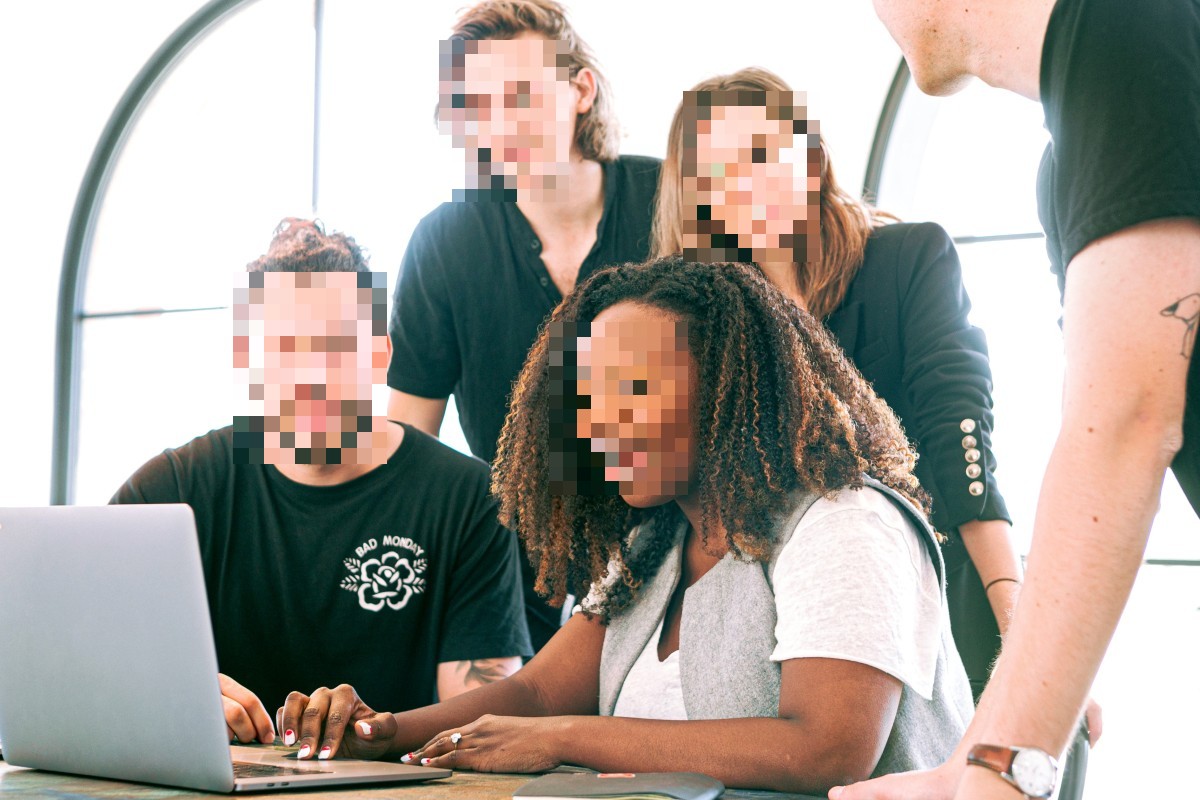

In [ ]:
img = load_img('test_images/group_closer.jpg')
show_cv2(anonymize(img, factor=1, mode='pixelate'))

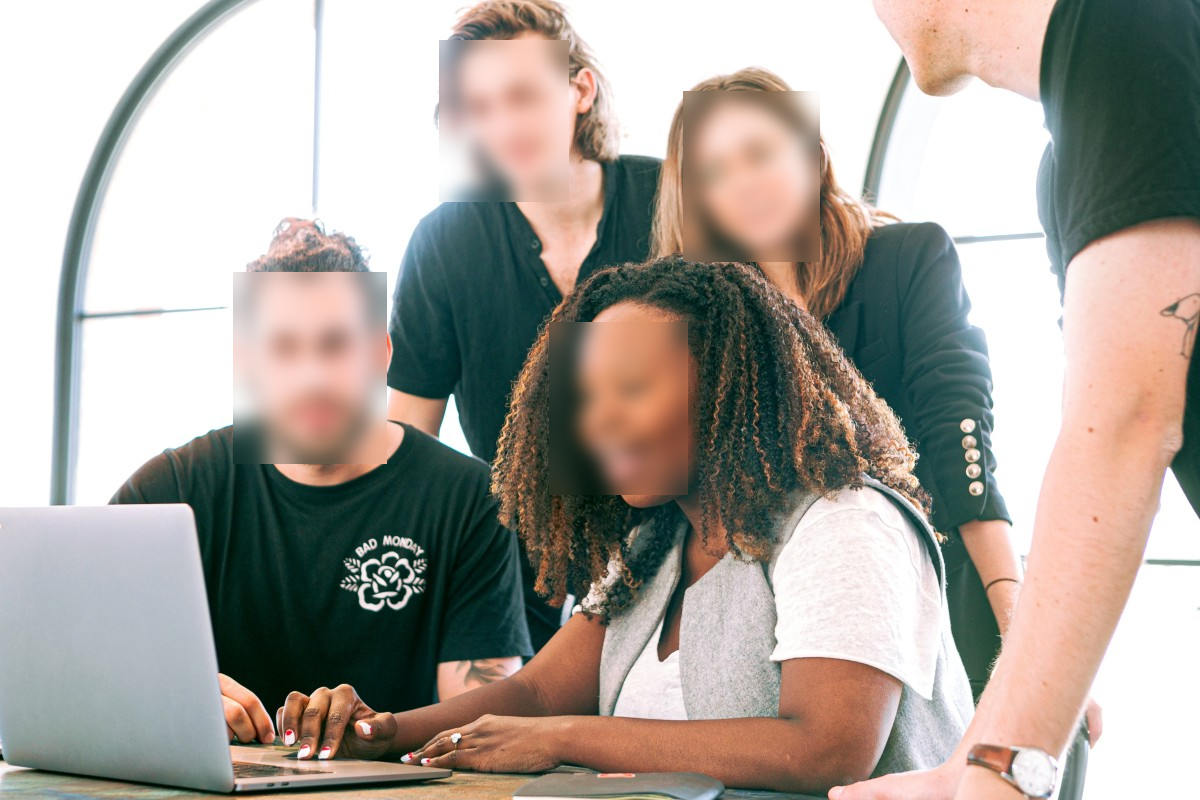

In [ ]:
img = load_img('test_images/group_closer.jpg')
show_cv2(anonymize(img, factor=1))

In [ ]:
def test_bulk(directory, **kwargs):
    path = Path(directory)
    for fn in path.ls():
        blurred = anonymize(load_img(fn), **kwargs)
        show_cv2(blurred)

In [ ]:
#test_bulk('test_images', factor=1, mode='blur')

## Streamlit App

In [ ]:
#export
path = Path('test_images')

In [ ]:
#Image.open(path/'small.jpg')

In [ ]:
#export
def get_image_download_link(img):
    """Generates a link allowing the PIL image to be downloaded
    in:  PIL image
    out: href string
    
    Source: https://discuss.streamlit.io/t/how-to-download-file-in-streamlit/1806/19
    """
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    href = f'<a href="data:file/jpg;base64,{img_str}" download="blurredfaces.jpg">Download result</a>'
    return href

In [ ]:
#export
st.title("Blurry Faces");
st.write("Upload any photo with people in it, and this tool will pixelate the faces.")

**TODO**: Example images

In [ ]:
#export
img1 = path/'group.jpg'
img2 = path/'group_closer.jpg'
img3 = path/'crowd.jpg'
st.image([Image.open(img1), Image.open(img2), Image.open(img3)], width=200)
example = st.radio("Choose an example image", ["Group", "Small group", "Large crowd"])
img_file = None
if example == "Group":
    img_file = img1
elif example == "Small group":
    img_file = img2
elif example == "Large crowd":
    img_file = img3

In [ ]:
#export
uploaded_file = st.file_uploader("Or upload a photo:", type=['png', 'jpg', 'jpeg'], accept_multiple_files=False)

In [ ]:
#export
if uploaded_file or img_file:
    if uploaded_file: file = uploaded_file
    elif img_file: file = img_file
    #st.write("Processing...")
    img = Image.open(file)
    img_array = np.array(img)
    anon_img = anonymize(img_array, mode='pixelate')
    anon_img_pil = Image.fromarray(anon_img)
    
    st.image(anon_img, caption=" ", use_column_width='auto')
    st.markdown(get_image_download_link(anon_img_pil), unsafe_allow_html=True)

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_webcam.ipynb.
Converted 02_cli.ipynb.
Converted index.ipynb.
